In [22]:
# Import
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, losses, metrics, optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.sparse import reorder
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from collections import Counter
from pathlib import Path
import os
import numpy as np
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import unicodedata
import html
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [119]:
# !rm -rf ...

In [14]:
DATA_PATH=Path('./')
DATA_PATH.mkdir(exist_ok=True)
!curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz -C {DATA_PATH}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  13.3M      0  0:00:06  0:00:06 --:--:-- 18.8M


In [2]:
CLASSES = ['neg', 'pos']
PATH=Path('./aclImdb/')

def get_texts(path):
  texts, labels = [], []
  for id, label in enumerate(CLASSES):
    for file in (path/label).glob('*.*'):
      texts.append(file.open('r', encoding='utf-8').read())
      labels.append(id)
  return texts, labels

In [3]:
train_text, train_labels = get_texts(PATH/'train')
test_text, test_labels = get_texts(PATH/'test')

In [123]:
train_text[0]

'Ludicrous. Angelic 9-year-old Annakin turns into whiny brat 19-year-old Annakin, who somehow seems appealing to Amidala, 5 years his senior. Now 22-year-old Jedi warrior hero Annakin has a couple of bad dreams, and so takes to slaughtering children, his friends, and the entire framework of his existence because a crazy old man convinced him a) his precious wife might really die, and b) only he can prevent this. Ludicrosity squared.<br /><br />I think the people who like this movie are not paying attention. The story is ridiculous. The characters are unbelievable (literally, not the perverted sense of "fantastic", "wonderful", etc.).<br /><br />Obi-wan Kenobi was the wise and kind anchor for the entire series, but in the climax, he hacks off Annakin\'s legs, lets him burn in the lava, and leaves him to suffer. Doesn\'t anyone think that\'s a little out of character? Not to mention it was pretty stupid to take a chance on him living, as it turns out.<br /><br />I was expecting at least 

# __The Full pipeline to go from the raw form to the prepared form__

# A - Text preprocessing

### 1- Data sequencing: each sentence be sequence (list) of words

### 2- Data cleaning: This step varies from task to task. For some tasks it's better to remove special characters and punctuations, for other they are critical (emotiocons).

### 3- Text normalization: in general text morphology is a big issue in NLP. Upper and lower cases, stemming and lemmatization, ... etc. It's task dependent.

### 4- Padding (model dependent): Dense and CNN. RNN can skip this step.

# B- Text preparation

### 5- (Binarization/vectorization/digitization): transform words into numbers according to a vocab index.

# First phase: text preprocessing
  - Clean text
  - Text-in and text-out

## Split text into sequence:
  - Manual (split on white spaces)
    - 
  - RegeX
  - Split on white spaces and punctuation

### Manual splitting

In [124]:
train_text[0].split()

['Ludicrous.',
 'Angelic',
 '9-year-old',
 'Annakin',
 'turns',
 'into',
 'whiny',
 'brat',
 '19-year-old',
 'Annakin,',
 'who',
 'somehow',
 'seems',
 'appealing',
 'to',
 'Amidala,',
 '5',
 'years',
 'his',
 'senior.',
 'Now',
 '22-year-old',
 'Jedi',
 'warrior',
 'hero',
 'Annakin',
 'has',
 'a',
 'couple',
 'of',
 'bad',
 'dreams,',
 'and',
 'so',
 'takes',
 'to',
 'slaughtering',
 'children,',
 'his',
 'friends,',
 'and',
 'the',
 'entire',
 'framework',
 'of',
 'his',
 'existence',
 'because',
 'a',
 'crazy',
 'old',
 'man',
 'convinced',
 'him',
 'a)',
 'his',
 'precious',
 'wife',
 'might',
 'really',
 'die,',
 'and',
 'b)',
 'only',
 'he',
 'can',
 'prevent',
 'this.',
 'Ludicrosity',
 'squared.<br',
 '/><br',
 '/>I',
 'think',
 'the',
 'people',
 'who',
 'like',
 'this',
 'movie',
 'are',
 'not',
 'paying',
 'attention.',
 'The',
 'story',
 'is',
 'ridiculous.',
 'The',
 'characters',
 'are',
 'unbelievable',
 '(literally,',
 'not',
 'the',
 'perverted',
 'sense',
 'of',
 '"f

We can notice the problem here punctuation is preserved! as "movie.", "movie!", "movie" ...
There are two issues:
  1. Increased vocab size that will lead to sparse and more memory
  2. What other forms we account for: 'movie!', 'movie:',...etc. Those are different and unexpected morphologies

__we aim at normalizing the text to common format as much as possible__

### Regex

In [125]:
re.split(r'\W+', train_text[0])

['Ludicrous',
 'Angelic',
 '9',
 'year',
 'old',
 'Annakin',
 'turns',
 'into',
 'whiny',
 'brat',
 '19',
 'year',
 'old',
 'Annakin',
 'who',
 'somehow',
 'seems',
 'appealing',
 'to',
 'Amidala',
 '5',
 'years',
 'his',
 'senior',
 'Now',
 '22',
 'year',
 'old',
 'Jedi',
 'warrior',
 'hero',
 'Annakin',
 'has',
 'a',
 'couple',
 'of',
 'bad',
 'dreams',
 'and',
 'so',
 'takes',
 'to',
 'slaughtering',
 'children',
 'his',
 'friends',
 'and',
 'the',
 'entire',
 'framework',
 'of',
 'his',
 'existence',
 'because',
 'a',
 'crazy',
 'old',
 'man',
 'convinced',
 'him',
 'a',
 'his',
 'precious',
 'wife',
 'might',
 'really',
 'die',
 'and',
 'b',
 'only',
 'he',
 'can',
 'prevent',
 'this',
 'Ludicrosity',
 'squared',
 'br',
 'br',
 'I',
 'think',
 'the',
 'people',
 'who',
 'like',
 'this',
 'movie',
 'are',
 'not',
 'paying',
 'attention',
 'The',
 'story',
 'is',
 'ridiculous',
 'The',
 'characters',
 'are',
 'unbelievable',
 'literally',
 'not',
 'the',
 'perverted',
 'sense',
 'of

This is better than manual split but what if we have "Animal-like robots are funny" ?

In [126]:
re.split(r"\W+", "Animal-like robots are funny")

['Animal', 'like', 'robots', 'are', 'funny']

This has another meaning entirely

### Split by white spaces and remove punctuation
In this technique we can handel the two issues above 

In [127]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [128]:
re_punc = re.compile('[%s]' % re.escape(string.punctuation))
# remove punctuation from each word
s = "Animal-like robots are funny!"
stripped = [re_punc.sub('', w) for w in s.split()]
stripped

['Animallike', 'robots', 'are', 'funny']

! is removed and Animalliked is kept not the same but still has the same meaning

#### What if we need to keep punctuation and don't effect on the meaning ?
  - we can use NLTK

In [129]:
word_tokenize('Animal-like robots are funny!')

['Animal-like', 'robots', 'are', 'funny', '!']

That's nice; we have the decision to keep punctuation or remove it, and also Animal-like has kept too

### Stop words
Not every word contribute to the semantics. Some words like 'the', 'to', 'on', 'we',...etc are not important for many tasks, specially classification tasks.

In [130]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [131]:
sentence = 'The dog is eating meat'
words = [w for w in sentence.split() if w not in stop_words]
words

['The', 'dog', 'eating', 'meat']

why `The` is there ?
  - because all stop words in lower case

### Stemming (prefixes and suffixes)
  - This step will reduce the redundancy. 
  - Mainly focused on morphology.

In [132]:
words = {'cat', 'dog', 'and'}
sentence = 'cats and dogs'
[1 for w in sentence.split() if w in words]

[1]

This is the problem we need to make dogs equal to dog

In [133]:
porter = PorterStemmer()
[1 for w in sentence.split() if porter.stem(w) in words]

[1, 1, 1]

Note: the stemming sometime produce meaningless words 

In [134]:
porter.stem('Little')

'littl'

Have you notice something ?
  - sure, the `stemming` is convert the word into `lower case`

### Lemmatization
Unlike stemming, lemmatization convert word to the root in the language
(is, are, am) convert to be

In [135]:
lemmatizer = WordNetLemmatizer()

sentence = 'The dogs are eating meat'
[lemmatizer.lemmatize(w) for w in sentence.split()]

['The', 'dog', 'are', 'eating', 'meat']

`are` is still are not `b`

### PoS tags
Part-of-Speech refers to the different classes a word like: none, verb, adjective, ...etc

In [136]:
sentence = 'The dogs are eating meat'
tagged = nltk.pos_tag(sentence.split())
tagged

[('The', 'DT'),
 ('dogs', 'NNS'),
 ('are', 'VBP'),
 ('eating', 'VBG'),
 ('meat', 'NN')]

lemmatizer.lemmatize() take an argument pos which is default as noun 'r'

let's use sentence that contain all of types

In [137]:
sentence = 'The bravely smiling girls quickly ran across the street'
print([lemmatizer.lemmatize(w, pos='v') for w in sentence.split()])
# another way of passing value to pos
print([lemmatizer.lemmatize(w, pos=wordnet.VERB) for w in sentence.split()])
# the rest types
print([lemmatizer.lemmatize(w, pos=wordnet.NOUN) for w in sentence.split()]) # 'n'
print([lemmatizer.lemmatize(w, pos=wordnet.ADJ) for w in sentence.split()])  # 'a'
print([lemmatizer.lemmatize(w, pos=wordnet.ADV) for w in sentence.split()])  # 'r'

['The', 'bravely', 'smile', 'girls', 'quickly', 'run', 'across', 'the', 'street']
['The', 'bravely', 'smile', 'girls', 'quickly', 'run', 'across', 'the', 'street']
['The', 'bravely', 'smiling', 'girl', 'quickly', 'ran', 'across', 'the', 'street']
['The', 'bravely', 'smiling', 'girls', 'quickly', 'ran', 'across', 'the', 'street']
['The', 'bravely', 'smiling', 'girls', 'quickly', 'ran', 'across', 'the', 'street']


### Either use stemming or lemmatization

stemming might make lemmatization not working

### Extra cleaning
  - We might encounter non ascii codes. In this case we need to decode Unicode characters into a normalized form, such as UTF8
  - Other special characters might exist due to html symbols and tags

Note: do this step first

In [138]:
sentence = 'the cat'
unicodedata.normalize('NFKD', sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore')

'the cat'

In [139]:
train_text[0]

'Ludicrous. Angelic 9-year-old Annakin turns into whiny brat 19-year-old Annakin, who somehow seems appealing to Amidala, 5 years his senior. Now 22-year-old Jedi warrior hero Annakin has a couple of bad dreams, and so takes to slaughtering children, his friends, and the entire framework of his existence because a crazy old man convinced him a) his precious wife might really die, and b) only he can prevent this. Ludicrosity squared.<br /><br />I think the people who like this movie are not paying attention. The story is ridiculous. The characters are unbelievable (literally, not the perverted sense of "fantastic", "wonderful", etc.).<br /><br />Obi-wan Kenobi was the wise and kind anchor for the entire series, but in the climax, he hacks off Annakin\'s legs, lets him burn in the lava, and leaves him to suffer. Doesn\'t anyone think that\'s a little out of character? Not to mention it was pretty stupid to take a chance on him living, as it turns out.<br /><br />I was expecting at least 

In [140]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('<br />', '\n').replace('@', ' ').replace('$', 'dollar')
    return re1.sub(' ', html.unescape(x))

re1.sub(' ', html.unescape(fixup('the <br />cat')))

'the \ncat'

## All the pipeline:

In [4]:
def remove_special_chars(text):
  re1 = re.compile(r'  +')
  text = text.replace('<br />', '\n').replace('@', ' ').replace('$', 'dollar')
  return re1.sub(' ', html.unescape(text))

def remove_non_ascii(text):
  return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def to_lower(text):
  return text.lower()

def remove_punctuation(text):
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  return re_punc.sub('', text)

def replace_numbers(text):
  return re.sub(r'\d+', '', text)

def remove_whitespaces(text):
  return text.strip()

def remove_stopwords(words, stop_words):
  return [word for word in words if word not in stop_words]

def stem_words(words):
  stemmer = PorterStemmer()
  return [stemmer.stem(word) for word in words]

def lemmatize(words):
  lemmatizer = WordNetLemmatizer()
  lem_verb = [lemmatizer.lemmatize(word, pos='v') for word in words]
  lem_noun = [lemmatizer.lemmatize(word, pos='n') for word in lem_verb]
  lem_adv = [lemmatizer.lemmatize(word, pos='r') for word in lem_noun]
  lem_adj = [lemmatizer.lemmatize(word, pos='a') for word in lem_adv]
  return ' '.join(lem_adj)

def text2words(text):
  return word_tokenize(text)

In [5]:
def normalize_text(text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lower(text)
    text = replace_numbers(text)
    words = remove_whitespaces(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    # words = stem_words(words) # stem or lemmatize 
    words = lemmatize(words)

    return ''.join(words)

In [19]:
normalize_text(train_text[0])

'everything id read movie excite support film christian theme everything movie unprofessionally do especially write without good write movie doesnt chance writerdirector say interview didnt want give away title relate story believe big surprise keep wait teenageyoung adult backstory unfold never someone go divorce disappoint movie would comfort first go emotional turmoil divorce bring life christian'

## Apply the pipeline in all data

In [6]:
def normalize_data(corpus):
  return [normalize_text(sentence) for sentence in corpus]

In [7]:
norm_train_text = normalize_data(train_text)
norm_test_text = normalize_data(test_text)

In [146]:
norm_train_text[0]

'ludicrous angelic yearold annakin turn whiny brat yearold annakin somehow seem appeal amidala year senior yearold jedi warrior hero annakin couple bad dream take slaughter child friend entire framework existence crazy old man convince precious wife might really die b prevent ludicrosity square think people like movie pay attention story ridiculous character unbelievable literally pervert sense fantastic wonderful etc obiwan kenobi wise kind anchor entire series climax hack annakins leg let burn lava leave suffer doesnt anyone think thats little character mention pretty stupid take chance live turn expect least story show consistent character plausible motivation none story could write year old oh yeah cgi pretty cool'

# Second phase: text preparation
  - Text-in and number-out

We can do that manually or using keras tokenization

### manually

In [22]:
# get all data
texts = norm_train_text + norm_test_text
# split to words
words = [word for text in texts for word in text.split()]
# apply set to remove redundancy and sort
vocab = sorted(list(set(words)))
vocab

['\x08\x08\x08\x08a',
 '\x10own',
 'aa',
 'aaa',
 'aaaaaaaaaaaahhhhhhhhhhhhhh',
 'aaaaaaaargh',
 'aaaaaaah',
 'aaaaaaahhhhhhggg',
 'aaaaagh',
 'aaaaah',
 'aaaaargh',
 'aaaaarrrrrrgggggghhhhhh',
 'aaaaatchkah',
 'aaaaaw',
 'aaaahhhhhh',
 'aaaahhhhhhh',
 'aaaand',
 'aaaarrgh',
 'aaaawwwwww',
 'aaaggghhhhhhh',
 'aaagh',
 'aaah',
 'aaahhhhhhh',
 'aaahthe',
 'aaall',
 'aaand',
 'aaargh',
 'aaarrrghim',
 'aaaugh',
 'aab',
 'aachen',
 'aada',
 'aadha',
 'aadmittedly',
 'aag',
 'aage',
 'aagh',
 'aaghh',
 'aah',
 'aahemy',
 'aahhh',
 'aahhhh',
 'aaila',
 'aailiyah',
 'aaip',
 'aaja',
 'aajala',
 'aak',
 'aakash',
 'aake',
 'aaker',
 'aakrosh',
 'aalcc',
 'aaliot',
 'aaliyah',
 'aaliyahs',
 'aalox',
 'aames',
 'aamess',
 'aamilne',
 'aamir',
 'aamirs',
 'aamirsalmanraveenakarishma',
 'aamr',
 'aan',
 'aanekoski',
 'aankh',
 'aankhen',
 'aaoon',
 'aap',
 'aapke',
 'aapkey',
 'aaran',
 'aardman',
 'aardmans',
 'aardvark',
 'aarf',
 'aargh',
 'aarghlets',
 'aarika',
 'aaron',
 'aaroncurb',
 'aaron

In [153]:
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for i,w in enumerate(vocab)}

In [154]:
word2idx

{'\x08\x08\x08\x08a': 0,
 '\x10own': 1,
 'aa': 2,
 'aaa': 3,
 'aaaaaaaaaaaahhhhhhhhhhhhhh': 4,
 'aaaaaaaargh': 5,
 'aaaaaaah': 6,
 'aaaaaaahhhhhhggg': 7,
 'aaaaagh': 8,
 'aaaaah': 9,
 'aaaaargh': 10,
 'aaaaarrrrrrgggggghhhhhh': 11,
 'aaaaatchkah': 12,
 'aaaaaw': 13,
 'aaaahhhhhh': 14,
 'aaaahhhhhhh': 15,
 'aaaand': 16,
 'aaaarrgh': 17,
 'aaaawwwwww': 18,
 'aaaggghhhhhhh': 19,
 'aaagh': 20,
 'aaah': 21,
 'aaahhhhhhh': 22,
 'aaahthe': 23,
 'aaall': 24,
 'aaand': 25,
 'aaargh': 26,
 'aaarrrghim': 27,
 'aaaugh': 28,
 'aab': 29,
 'aachen': 30,
 'aada': 31,
 'aadha': 32,
 'aadmittedly': 33,
 'aag': 34,
 'aage': 35,
 'aagh': 36,
 'aaghh': 37,
 'aah': 38,
 'aahemy': 39,
 'aahhh': 40,
 'aahhhh': 41,
 'aaila': 42,
 'aailiyah': 43,
 'aaip': 44,
 'aaja': 45,
 'aajala': 46,
 'aak': 47,
 'aakash': 48,
 'aake': 49,
 'aaker': 50,
 'aakrosh': 51,
 'aalcc': 52,
 'aaliot': 53,
 'aaliyah': 54,
 'aaliyahs': 55,
 'aalox': 56,
 'aames': 57,
 'aamess': 58,
 'aamilne': 59,
 'aamir': 60,
 'aamirs': 61,
 'aamirs

In [155]:
sentence = 'like movie'
[word2idx[w] for w in sentence.split()]

[70204, 80721]

### Keras Tokenizer

In [10]:
token = Tokenizer()
token.fit_on_texts(texts)

In [158]:
token.word_index

{'movie': 1,
 'film': 2,
 'one': 3,
 'make': 4,
 'like': 5,
 'see': 6,
 'get': 7,
 'well': 8,
 'time': 9,
 'good': 10,
 'character': 11,
 'watch': 12,
 'go': 13,
 'bad': 14,
 'even': 15,
 'story': 16,
 'think': 17,
 'would': 18,
 'really': 19,
 'show': 20,
 'scene': 21,
 'great': 22,
 'look': 23,
 'say': 24,
 'much': 25,
 'know': 26,
 'end': 27,
 'people': 28,
 'also': 29,
 'give': 30,
 'first': 31,
 'take': 32,
 'act': 33,
 'play': 34,
 'love': 35,
 'way': 36,
 'dont': 37,
 'come': 38,
 'thing': 39,
 'find': 40,
 'could': 41,
 'seem': 42,
 'work': 43,
 'many': 44,
 'plot': 45,
 'actor': 46,
 'want': 47,
 'two': 48,
 'never': 49,
 'year': 50,
 'best': 51,
 'try': 52,
 'little': 53,
 'life': 54,
 'ever': 55,
 'man': 56,
 'still': 57,
 'feel': 58,
 'part': 59,
 'something': 60,
 'use': 61,
 'lot': 62,
 'funny': 63,
 'back': 64,
 'interest': 65,
 'im': 66,
 'director': 67,
 'old': 68,
 'real': 69,
 'guy': 70,
 'performance': 71,
 'doesnt': 72,
 'didnt': 73,
 'woman': 74,
 'though': 75,
 '

when we do it manually the index starts from 0 but in Keras Tokenizer starts from 1 why ?
  - For padding

Put oov_token='UNK' to put index 1 for unknown words

In [30]:
token = Tokenizer(oov_token='UNK')
token.fit_on_texts(texts)

In [12]:
token.word_index['UNK']

1

we can also maximum words in tokenizer by put num_words=any given number

In [31]:
bow = token.texts_to_matrix(texts[:10], mode='count')
bow.shape

(10, 140246)

### what is the mode ?

## In BoW with Keras tokenizer there are 4 different encode:
  1. binary: Whether or not each word is present in the document. This is the default.
  2. count: The count of each word in the document.
    - Not normalized
  3. tfidf: The Text Frequency-Inverse DocumentFrequency (TF-IDF) scoring for each word in the document (more on that later).
    - Not normalized in keras
  4. freq: The frequency of each word as a ratio of words within each document.
    - Normalized

## In BoW with scikit-learn tokenizer there are 2 different ways:
  1. CountVectorizer
    - Not normalied
  2. TfidfVectorizer
    - Normalized

## Let's use TfidfVectorizer

In [29]:
vocab_sz = 10000
vectorizer = TfidfVectorizer(max_features=vocab_sz)
# tokenize and build vocab
vectorizer.fit(norm_train_text+norm_test_text)


x_train = vectorizer.transform(norm_train_text)
x_test = vectorizer.transform(norm_test_text)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [15]:
x_train.shape

(25000, 10000)

In [31]:
x_train = x_train.toarray()
x_test = x_test.toarray()

We need to shuffle training data before the model

In [32]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

In [33]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
30/30 [==============================] - 4s 59ms/step - loss: 0.6573 - binary_accuracy: 0.6134 - val_loss: 0.6160 - val_binary_accuracy: 0.7645
Epoch 2/20
30/30 [==============================] - 1s 45ms/step - loss: 0.5668 - binary_accuracy: 0.7959 - val_loss: 0.5396 - val_binary_accuracy: 0.8222
Epoch 3/20
30/30 [==============================] - 1s 48ms/step - loss: 0.4793 - binary_accuracy: 0.8654 - val_loss: 0.4688 - val_binary_accuracy: 0.8462
Epoch 4/20
30/30 [==============================] - 1s 45ms/step - loss: 0.3963 - binary_accuracy: 0.9021 - val_loss: 0.4045 - val_binary_accuracy: 0.8701
Epoch 5/20
30/30 [==============================] - 1s 45ms/step - loss: 0.3211 - binary_accuracy: 0.9223 - val_loss: 0.3533 - val_binary_accuracy: 0.8761
Epoch 6/20
30/30 [==============================] - 1s 45ms/step - loss: 0.2581 - binary_accuracy: 0.9343 - val_loss: 0.3207 - val_binary_accuracy: 0.8779
Epoch 7/20
30/30 [==============================] - 1s 45ms/step - los

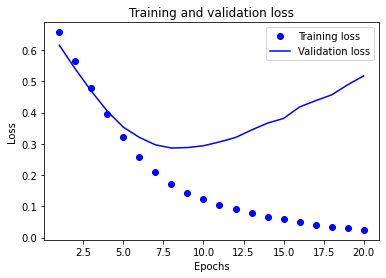

In [34]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

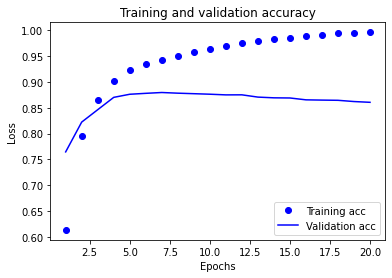

In [36]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Reference:
  - Big thanks for Coursat.ai (Dr. Ahmad ElSallab)